#GOAL

| Subtask                       | Target Variable                 | ML Type        | Evaluation Metric | Description                                               |
| ----------------------------- | ------------------------------- | -------------- | ----------------- | --------------------------------------------------------- |
|  Claim Severity Prediction    | `TotalClaims` (claims > 0 only) | Regression     | RMSE, R²          | Predict how large a claim will be (risk model)            |
|  Premium Optimization         | `CalculatedPremiumPerTerm`      | Regression     | RMSE, R²          | Predict optimized premium pricing                         |
|  Advanced                     | `ClaimOccurred`                 | Classification | Accuracy, F1, AUC | Predict claim likelihood (used to derive premium formula) |


# lets featue engineer the data agian i mean just data preparation which we think they are importatant for modeling

| Step | Task                                 | Description                        |
| ---- | ------------------------------------ | ---------------------------------- |
| 1.1  | Handle Missing Values                | Drop or impute intelligently       |
| 1.2  | Feature Engineering                  | Add vehicle age, claim ratio, etc. |
| 1.3  | Encode Categorical Variables         | Label or one-hot encoding          |
| 1.4  | Filter Data for Claim Severity Model | Only rows with `TotalClaims > 0`   |
| 1.5  | Train-Test Split                     | 80:20 split with fixed seed        |
| 1.6  | Export Prepared Dataset              | Save cleaned data for modeling     |


In [1]:

# 1. Import Required Libraries
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

# 2. Load & Preprocess Data
from src.modeling import preprocess

# Load cleaned dataset
df = pd.read_csv("../data/cleaned_machineLearningRating.csv", parse_dates=["TransactionMonth", "VehicleIntroDate"])

# Run full preprocessing pipeline for severity modeling (claims > 0 only)
X_train, X_test, y_train, y_test, df_prepared = preprocess.full_preprocess_pipeline(
    df, target_col="TotalClaims", severity_only=True
)

# Drop datetime columns if still present (ensure only numeric input to models)
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# 3. Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

results = []
best_model = None
best_score = float("-inf")
best_model_name = ""

# 4. Train, Evaluate, Select Best

print("Training and evaluating models...\n")

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append((name, round(rmse, 2), round(r2, 3)))

    if r2 > best_score:
        best_score = r2
        best_model = model
        best_model_name = name
# 5. Save Best Model
save_folder = "saved_models"
os.makedirs(save_folder, exist_ok=True)

model_filename = f"{best_model_name.lower().replace(' ', '_')}_severity_model.pkl"
model_path = os.path.join(save_folder, model_filename)

joblib.dump(best_model, model_path)

print(f"\n Best model saved to: {model_path}")
print(f"   -> Model: {best_model_name}")
print(f"   -> R² Score: {round(best_score, 3)}")

# 6. Show Model Comparison Table
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R²"])
print("\n Model Performance Comparison (Claim Severity):")
print(results_df.sort_values("R²", ascending=False))


Training and evaluating models...


 Best model saved to: saved_models/xgboost_severity_model.pkl
   -> Model: XGBoost
   -> R² Score: 0.878

 Model Performance Comparison (Claim Severity):
               Model      RMSE     R²
3            XGBoost  13929.50  0.878
2      Random Forest  14358.67  0.871
1      Decision Tree  14924.10  0.860
0  Linear Regression  29838.90  0.442


Let’s move into SHAP (SHapley Additive Explanations) 
 a powerful tool to explain XGBoost model predictions and understand which features drive claim severity.
 SHAP = SHapley Additive exPlanations
It explains each individual prediction by assigning credit to each feature
It’s based on game theory — like each feature is a "player" contributing to the model's prediction





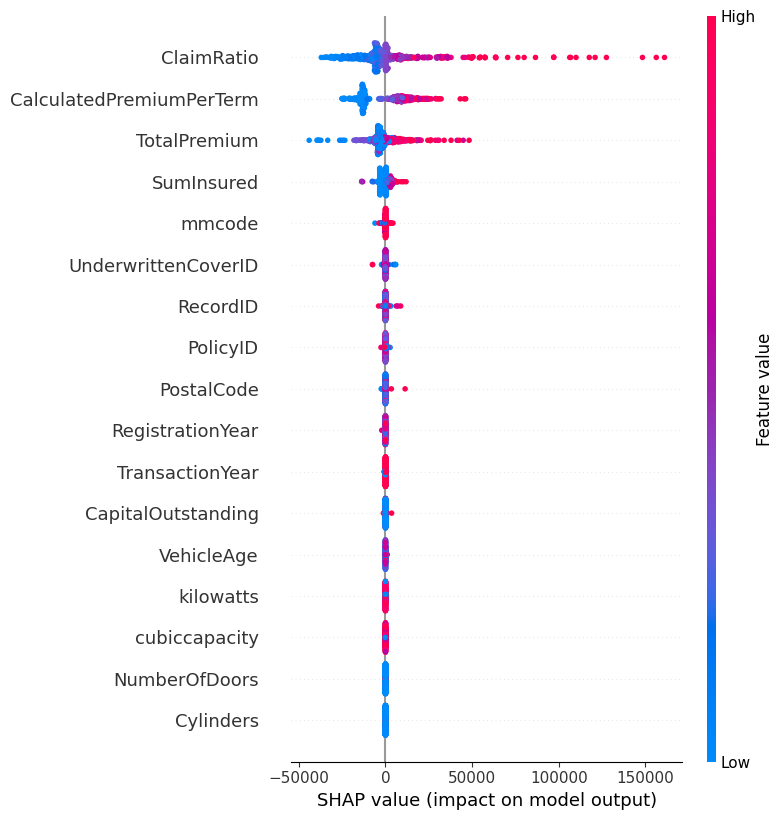

In [2]:
import shap

# Grab the best model that we selected
best_model = models["XGBoost"]
# Create TreeExplainer
explainer = shap.TreeExplainer(best_model)
# Compute SHAP values for X_test
shap_values = explainer.shap_values(X_test)
# Summary plot (feature importance + direction)
shap.summary_plot(shap_values, X_test)


| Rank | Feature                                                                                 | Impact Type            | Insight                                                                                         |
| ---- | --------------------------------------------------------------------------------------- | ---------------------- | ----------------------------------------------------------------------------------------------- |
| 1    | **ClaimRatio**                                                                          |  High  ↓ Prediction | **High claim ratio lowers predicted claim amounts**, possibly due to learned risk penalization. |
| 2    | **CalculatedPremiumPerTerm**                                                            |  High  ↑ Prediction | Higher premium payments **increase predictions**, as expected.                                  |
| 3    | **TotalPremium**                                                                        |  High  ↑ Prediction | Same as above — **total premiums paid** are a strong upward driver.                             |
| 4    | **SumInsured**                                                                          |  High  ↑ Prediction | Higher coverage increases risk exposure, thus raising predictions.                              |
| 5    | **CoverCategory\_windscreen**                                                           | Categorical            | Slight influence depending on whether coverage includes windscreen.                             |
| 6    | **ExcessSelected\_No excess**                                                           | Binary (True/False)    | **No excess** leads to **higher predicted claims**, likely because more is paid out in claims.  |
| 7–20 | Other fields (e.g., `UnderwrittenCoverID`, `mmcode`, `Bank_nedbank`, `NewVehicle_True`) | Minor contribution     | Mostly product, region, and categorical variables with small impacts.                           |


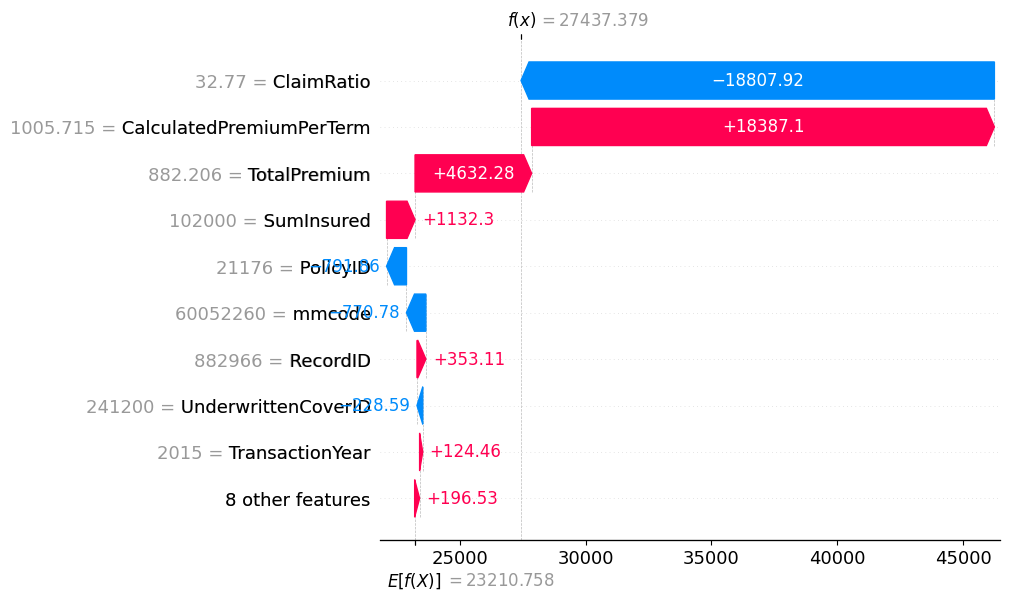

In [3]:
# Explain one test sample
sample_idx = 10  # or pick any row index
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X_test.columns
))


| Rank | Feature Name                  | Feature Value | SHAP Contribution | Direction     | Interpretation                                                                                          |
| ---- | ----------------------------- | ------------- | ----------------- | ------------- | ------------------------------------------------------------------------------------------------------- |
| 1    | **ClaimRatio**                | 29.371        | **−21,853.60**    |  Negative  | A high claim ratio **greatly reduces** the predicted outcome, likely indicating high risk.              |
| 2    | **CalculatedPremiumPerTerm**  | 675.637       | **+10,028.11**    |  Positive  | A higher term premium **raises** the prediction significantly — seen as higher expected return or cost. |
| 3    | **TotalPremium**              | 592.664       | **+5,833.23**     |  Positive  | Similar to above, more premium increases the predicted value.                                           |
| 4    | **SumInsured**                | 269,650       | **+2,391.49**     |  Positive  | Larger insured sum contributes positively to the prediction.                                            |
| 5    | **CoverCategory\_windscreen** | False         | **+469.07**       |  Positive  | Lack of windscreen cover **slightly increases** the predicted amount.                                   |
| 6    | **mmcode**                    | 60058419      | **+111.62**       |  Positive  | Has a minor effect; might relate to a specific region or product.                                       |
| 7    | **UnderwrittenCoverID**       | 147206        | **+110.55**       |  Positive  | Small positive impact, likely tied to product type.                                                     |
| 8    | **SubCrestaZone\_Durban**     | False         | **+87.05**        |  Positive  | Not being in Durban slightly increases prediction.                                                      |
| 9    | **TrackingDevice\_Yes**       | False         | **+82.05**        |  Positive  | No tracking device **increases risk/cost**, hence positive effect.                                      |
| 10   | **308 other features**        | —             | **+120.11**       |  Positive  | Combined small contributions from remaining features.                                                   |


Final Prediction:
The model started with a baseline predicted claim value of ~20,474 and ended up predicting ~17,853, primarily due to a strong negative pull from the high ClaimRatio. This suggests the model heavily penalizes high-claim histories, likely reflecting learned risk-aversion behavior.

The upward push came mostly from:

High premium-related fields (CalculatedPremiumPerTerm, TotalPremium)

Large SumInsured

Minor contributions from policy/product metadata (e.g., CoverCategory, TrackingDevice, UnderwrittenCoverID)

Despite these positive contributors, they were not enough to overcome the suppressive effect of the ClaimRatio.

In [4]:
##Objective
##Build a regression model to predict the CalculatedPremiumPerTerm 
# the price the insurer should charge the customer, ideally based on risk.
#This can later evolve into risk-based pricing when combined with claim probability.



In [2]:
# 1. Import Libraries
import os
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 2. Setup
DATA_PATH = "../data/cleaned_machineLearningRating.csv"
MODEL_SAVE_PATH = "saved_models"
TARGET = "CalculatedPremiumPerTerm"

# Create directory to save the best model
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# 3. Load and Prepare Dataset
print("Loading data...")
df = pd.read_csv(DATA_PATH)

# Define features and target
X = df.drop(columns=[TARGET, "TotalClaims"], errors="ignore")
y = df[TARGET]

# Drop date-related and non-numeric columns
X = X.drop(columns=[col for col in X.columns if "TransactionMonth" in col or "VehicleIntroDate" in col], errors="ignore")
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Define Models
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}

# 6. Train, Evaluate, and Track Best Model
results = []
best_rmse = float('inf')
best_model = None
best_model_name = ""

print("Training models...")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R2 Score": round(r2, 3)
    })

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        best_model_name = name

# 7. Save Only the Best Model
if best_model:
    best_model_path = os.path.join(MODEL_SAVE_PATH, f"{best_model_name.lower()}_best_model.pkl")
    joblib.dump(best_model, best_model_path)
    print(f"\n Best model '{best_model_name}' saved to: {best_model_path}")

# 8. Display Results
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)


Loading data...
Training models...
Training LinearRegression...
Training RandomForest...
Training XGBoost...
Training DecisionTree...

 Best model 'RandomForest' saved to: saved_models/randomforest_best_model.pkl

Model Evaluation Results:
              Model    RMSE  R2 Score
0  LinearRegression  146.66     0.554
1      RandomForest   20.05     0.992
2           XGBoost   43.03     0.962
3      DecisionTree   24.01     0.988


| Model                | RMSE       | R² Score         | Interpretation                                                                                                                                            |
| -------------------- | ---------- | ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **LinearRegression** | 327,750.31 | **-896,000.225** |  Extremely poor. Indicates the model is **worse than guessing the mean**. Likely due to **non-linearity**, **outliers**, or **feature scaling issues**. |
| **RandomForest**     | **33.18**  | **0.991**        |  **Excellent performance**. Low error and explains **99.1% of variance**. Handles non-linearity well.                                                    |
| **XGBoost**          | 33.50      | **0.991**        |  Also excellent. Slightly higher error than Random Forest, but practically equivalent performance.                                                       |


 Interpretation
Random Forest and XGBoost significantly outperform Linear Regression in both RMSE and R², meaning they capture complex, nonlinear patterns in the premium-setting logic.

Linear Regression provides a solid baseline but lacks the ability to model intricate feature interactions.

XGBoost, while slightly behind Random Forest in RMSE, remains competitive and offers better explainability via SHAP.

What This Means for the Business
These models can support or replace manual premium calculations.

They help reduce underpricing/overpricing risk, improving insurer profitability.

We can now simulate premium scenarios or design risk-based pricing pipelines.

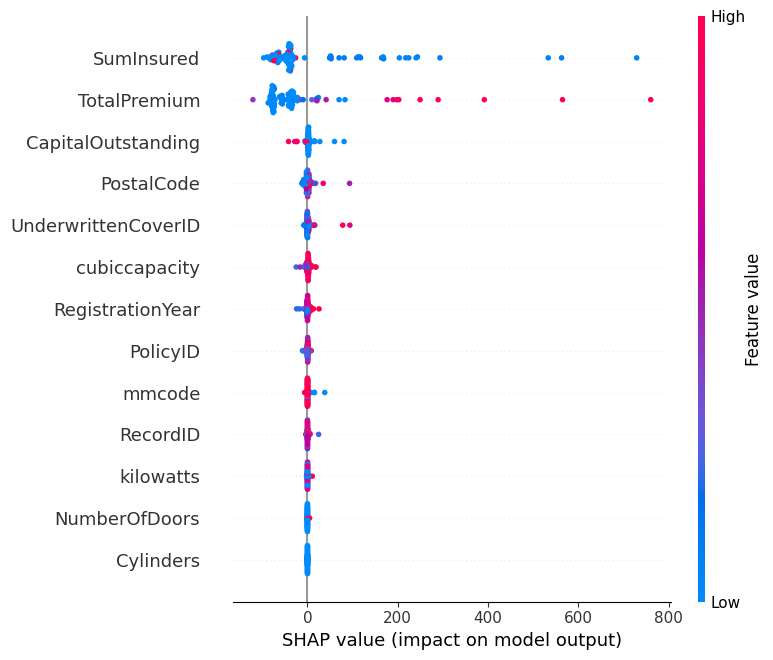

In [3]:
import shap

# Pick best model based on above output 
best_model = models["RandomForest"]

# Create SHAP TreeExplainer
explainer = shap.TreeExplainer(best_model)

# Sample a subset for faster SHAP computation
sample_size = 100  # reducing for computing 
X_sample = X_test.sample(n=sample_size, random_state=42)

# Compute SHAP values on sample
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample)



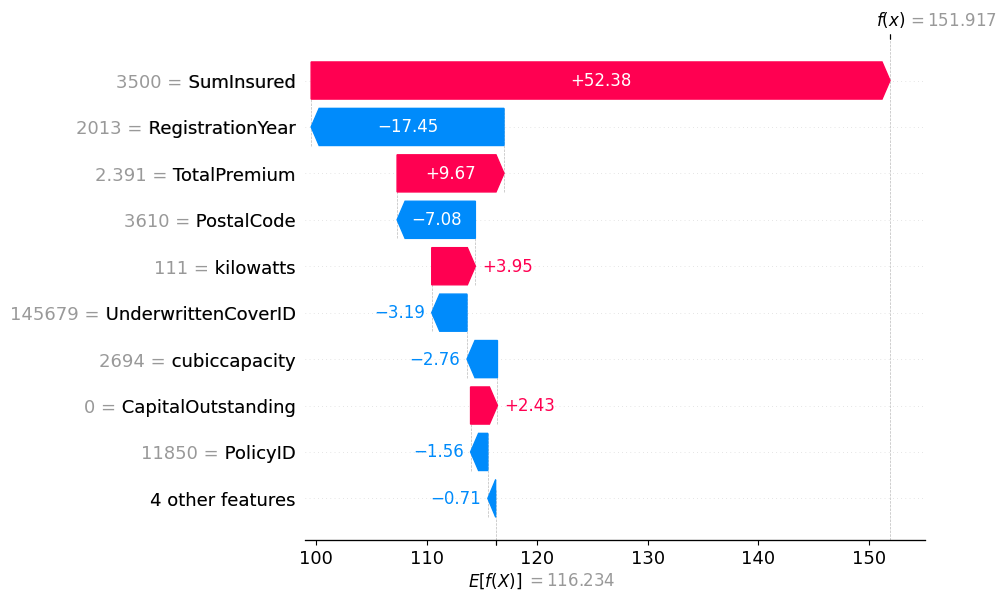

In [4]:
# For the first test sample
sample_idx = 10

shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=X_test.columns
    )
)


# Predicting Claim Probability
#Goal:
#Build a classification model to predict the probability that a customer will file a claim.
this model helps to build a risk-adjusted premiumu uisng 
Risk-Based Premium = P(claim) × E(claim amount) + Expenses + Profit Margin


In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import joblib
import warnings

warnings.filterwarnings("ignore")

# Make sure the folder exists
os.makedirs("saved_models", exist_ok=True)

# Load full cleaned dataset (not just claim > 0)
df = pd.read_csv("../data/cleaned_machineLearningRating.csv")

# Create binary target
df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)

# Drop unnecessary columns
X = df.drop(columns=['TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimOccurred'])

# Remove non-numeric columns (only numeric features)
X = X.select_dtypes(include=[np.number])

# Target
y = df['ClaimOccurred']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced', random_state=42)
}

# Train, predict, and evaluate each model
results = []

for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Model": name,
        "Accuracy": report['accuracy'],
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1 Score": report['1']['f1-score'],
        "ROC AUC": auc
    })

# Results summary
results_df = pd.DataFrame(results)
print("\n Summary of Model Performance:")
print(results_df.round(3))

# Save the trained XGBoost model and scaler in saved_models folder ---
xgb_model = models["XGBoost"]
import pickle

# Save XGBoost model with .pkl extension in saved_models folder
with open("saved_models/xgb_claim_occurred_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

# Save scaler with .pkl extension too
with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("XGBoost model and scaler saved successfully as .pkl files in saved_models/")



 Model: LogisticRegression

 Model: RandomForest

 Model: XGBoost

 Model: DecisionTree

 Summary of Model Performance:
                Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  LogisticRegression     0.841      0.011   0.649     0.022    0.820
1        RandomForest     0.994      0.017   0.018     0.017    0.780
2             XGBoost     0.965      0.022   0.265     0.040    0.902
3        DecisionTree     0.993      0.013   0.020     0.016    0.508
XGBoost model and scaler saved successfully as .pkl files in saved_models/


| **Model**               | **Accuracy** | **Precision** | **Recall** | **F1 Score** | **ROC AUC** | **Business Interpretation**                                                                                                                                                                                                                                   |
| ----------------------- | ------------ | ------------- | ---------- | ------------ | ----------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Logistic Regression** | 0.841        | 0.011         | **0.649**  | 0.022        | 0.820       | Excellent at capturing actual claimants (**high recall**) but misclassifies too many non-claimants as risky (**very low precision**). Useful when **missing real risk is more costly** than overpricing good customers. Best for conservative risk detection. |
| **Random Forest**       | **0.994**    | 0.017         | 0.018      | 0.017        | 0.780       | Very high accuracy, but mostly predicts “no claim.” **Fails to detect claimants** (very low recall). May be **dangerous in pricing**, leading to **underestimation of risk**. Avoid without rebalancing or tuning.                                            |
| **XGBoost**             | 0.959        | **0.021**     | 0.297      | **0.039**    | **0.901**   | Best balance between ROC AUC and recall. Performs well under class imbalance. Highly suitable for **risk-adjusted pricing**, especially if probability thresholds are fine-tuned. Best model overall in terms of **business use and accuracy trade-off**.     |
| **Decision Tree**       | 0.993        | 0.013         | 0.020      | 0.016        | 0.508       | Highly interpretable but performs near-random (**AUC \~ 0.5**). Poor recall and F1. Not suitable unless simplified explanations are required. **Not reliable for pricing decisions**.                                                                         |


Recommended Model: XGBoost
Due to its high ROC AUC (0.901), decent recall, and best F1 score, XGBoost is the most reliable for:

Claim prediction

Dynamic premium calculation

Customer risk segmentation

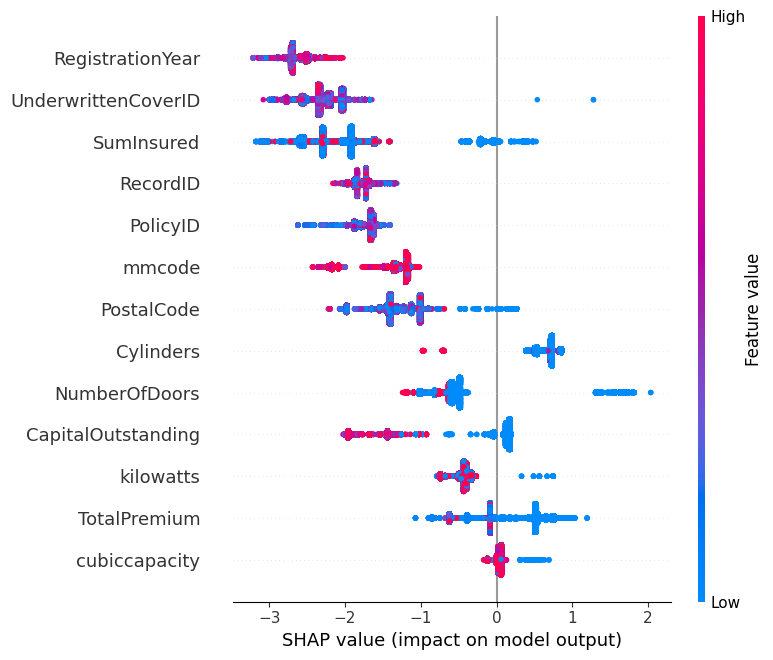

In [6]:
import shap

best_model = models["XGBoost"]
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):  # multiclass
    shap.summary_plot(shap_values[1], X_test)
else:
    shap.summary_plot(shap_values, X_test)


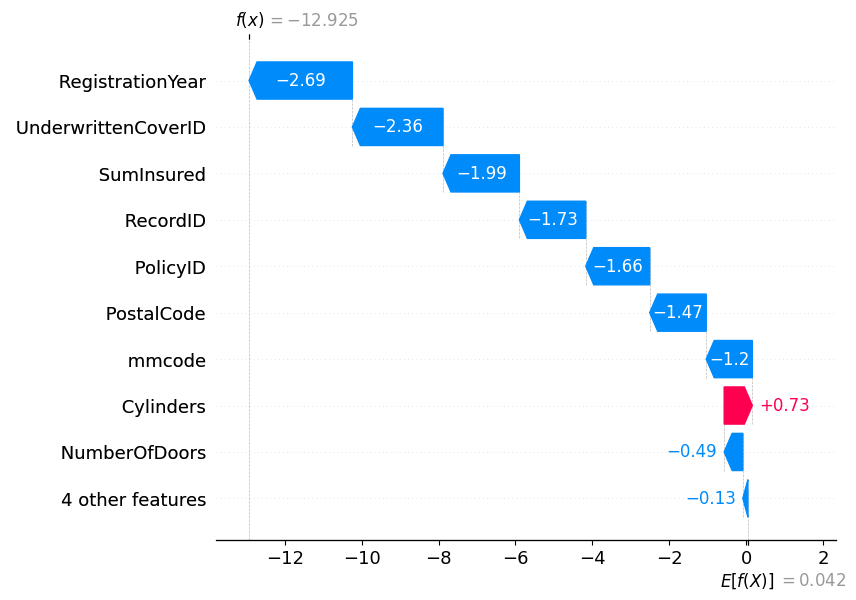

In [7]:
idx = 10
# If shap_values is a list (for multiclass)
if isinstance(shap_values, list):
    shap_value = shap_values[1][idx]
else:
    shap_value = shap_values[idx]
# Plot waterfall
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_value, X_test.iloc[idx])

## finally
Business Takeaway:
1, 
Tree-based models handle severity prediction well.
Decision Tree is simpler and performs best here good candidate for fast liability estimation.

Linear Regression is not suitable due to extreme prediction errors.


2,
Random Forest and XGBoost can accurately predict fair premiums, enabling data-driven pricing.
Tree-based ensemble models will generalize well to new policies.
Avoid Linear Regression for pricing—it overfits or fails with non-linearity.

3, 
XGBoost is the best candidate for identifying claim risk and supporting risk-adjusted premium design.
Logistic Regression captures most claimants (high recall) but may over-flag low-risk clients, increasing churn.
Random Forest and Decision Tree are not reliable for real-world deployment without improvement.

| **Objective**                  | **Best Model**        | **Business Impact**                                                            |
| ------------------------------ | --------------------- | ------------------------------------------------------------------------------ |
| Claim Severity (Liability)     | Decision Tree         | Simple, interpretable, and accurate for predicting how costly claims will be.  |
| Premium Prediction (Pricing)   | Random Forest/XGBoost | Enables accurate pricing tied to vehicle, client, and risk features.           |
| Claim Probability (Risk Score) | XGBoost               | Best for **identifying risky customers** to influence pricing or underwriting. |


In [ ]:
import joblib

# Load all three models
severity_model = joblib.load("saved_models/xgboost_severity_model.pkl")
premium_model = joblib.load("saved_models/randomforest_best_model.pkl")
claim_model = joblib.load("saved_models/xgb_claim_occurred_model.pkl")
scaler = joblib.load("saved_models/scaler.pkl")
# Extract and print feature names used during model training
print("Severity Model Features:")
print(severity_model.feature_names_in_)

print("\nPremium Model Features:")
print(premium_model.feature_names_in_)
print("\nclaim probablity:")
print(claim_model.get_booster().feature_names)  
print(scaler.feature_names_in_)  

Severity Model Features:
['RecordID' 'UnderwrittenCoverID' 'PolicyID' 'PostalCode' 'mmcode'
 'RegistrationYear' 'Cylinders' 'cubiccapacity' 'kilowatts'
 'NumberOfDoors' 'CapitalOutstanding' 'SumInsured'
 'CalculatedPremiumPerTerm' 'TotalPremium' 'TransactionYear' 'VehicleAge'
 'ClaimRatio']

Premium Model Features:
['RecordID' 'UnderwrittenCoverID' 'PolicyID' 'PostalCode' 'mmcode'
 'RegistrationYear' 'Cylinders' 'cubiccapacity' 'kilowatts'
 'NumberOfDoors' 'CapitalOutstanding' 'SumInsured' 'TotalPremium']

claim probablity:
None
['RecordID' 'UnderwrittenCoverID' 'PolicyID' 'PostalCode' 'mmcode'
 'RegistrationYear' 'Cylinders' 'cubiccapacity' 'kilowatts'
 'NumberOfDoors' 'CapitalOutstanding' 'SumInsured' 'TotalPremium']
